# Analysis dataset toy

In [1]:
import numpy as np
import pickle as pkl
from multiprocessing import Pool
from p_tqdm import p_map
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
# dataset folder
folder_dataset = ('/data/vision/torralba/frames/data_acquisition/SyntheticStories/online_wah/'
                 'agent_preferences/dataset/')
pkl_file = f'{folder_dataset}/dataset_graph_pred_30step_train.pkl'

with open(pkl_file, 'rb') as f:
    cont = pkl.load(f)

In [3]:
def get_task_type(episode_content):
    if type(episode_content) == str:
        with open(episode_content, 'rb') as f:
            episode_content = pkl.load(f)
    goals = episode_content['gt_goals']
    num_preds = sum(goals.values())
    name_preds = [goal_name.split('_')[1] for goal_name in goals.keys()]

    if 'cupcake' in name_preds or 'apple' in name_preds:
        return {"pred_name": "cupcake/apple", "num_preds": num_preds}
    else:
        return {"pred_name": "plate/glass", "num_preds": num_preds}
    

In [6]:
def get_task_info(episode_content):
    if type(episode_content) == str:
        with open(episode_content, 'rb') as f:
            episode_content = pkl.load(f)
    
    length = len(episode_content['action'][0])
    
    # Check distribution of objects
    first_graph = episode_content['graph'][0]
    objects_interest = ['plate', 'apple', 'cupcake', 'waterglass']
    obj2id = {name:index for index, name in enumerate(objects_interest)}
    
    object_relation_count = {}
    count_obj = [0 for _ in objects_interest]
    for object_name in objects_interest: 
        object_relation_count[object_name] = []
        
    id2node = {node['id']: node for node in first_graph['nodes']}
    
    # For every destination object, check the different locations
    for edge in first_graph['edges']:
        class_name = id2node[edge['from_id']]['class_name']
        if class_name in objects_interest:
            class_name_dest = id2node[edge['to_id']]['class_name']
            relation = edge['relation_type'].lower()
            
            full_relation_name = f'{relation}.{class_name_dest}'
            object_relation_count[class_name].append(full_relation_name)
    
    for node in first_graph['nodes']:
        class_name = node['class_name']
        if class_name in objects_interest:
            class_name_id = obj2id[class_name]
            count_obj[class_name_id] += 1
            
    # Counter over relations
    for class_name in objects_interest:
        object_relation_count[class_name] = Counter(object_relation_count[class_name])
    
    info = get_task_type(episode_content)
    info.update({'count_obj': count_obj})
    info.update({'obj_relations': object_relation_count})
    info['len_prog'] = length
    info['finished'] = episode_content['finished']
    return info
    

In [7]:
episodes = list(cont.keys())
with open(episodes[0], 'rb') as f:
    content_episode = pkl.load(f)

In [9]:
results = p_map(get_task_info, episodes)

In [10]:
res = [res for res in results if not res['finished']]


In [12]:
len(res)

0

In [248]:
names = ["cupcake/apple", "plate/glass"]
objects_interest = ['plate', 'apple', 'cupcake', 'waterglass']


In [153]:

name_dict = {name: it for it, name in enumerate(names)}
count_episodes = [0, 0]
count_pred = [0, 0]
count_length = [0, 0]
for pred_dict in results:
    res, npred, length = pred_dict['pred_name'], pred_dict['num_preds'], pred_dict['len_prog']
    index = name_dict[res]
    count_episodes[index] += 1
    count_pred[index] += npred
    count_length[index] += length
    
for ind in range(len(names)):
    count_pred[ind] *= 1.0 / count_episodes[ind]  
    count_length[ind] *= 1.0 / count_episodes[ind]  

In [271]:
# Get object counts
obj_counts = [[], []]
for result in results:
    task_name = result['pred_name']
    task_id = name_dict[task_name]
    obj_counts[task_id].append(np.array(result['count_obj'])[None, ])
    

In [272]:
all_count_max, all_count_mean = [None,None], [None, None]
for it in range(len(names)):
    all_counts = np.concatenate(obj_counts[it])
    print(all_counts.shape)
    all_count_mean[it] = np.mean(all_counts, axis=0)
    all_count_max[it] = np.max(all_counts, axis=0)

(697, 4)
(526, 4)


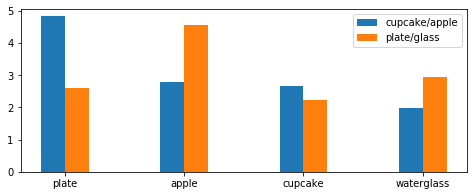

In [273]:
fig, ax2 = plt.subplots(1,1, figsize=(8,3))
x = np.array(range(len(objects_interest)))
ax2.bar(x-0.1, list(all_count_mean[0]), width=0.2, label=names[0])
ax2.bar(x+0.1, list(all_count_mean[1]), width=0.2, label=names[1])
ax2.set_xticks(x)
ax2.set_xticklabels(objects_interest)
plt.legend()

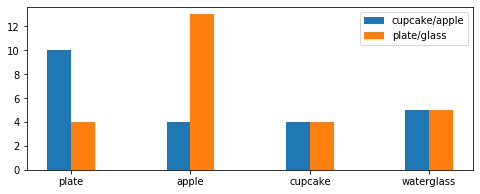

In [274]:
fig, ax2 = plt.subplots(1,1, figsize=(8,3))
x = np.array(range(len(objects_interest)))
ax2.bar(x-0.1, list(all_count_max[0]), width=0.2, label=names[0])
ax2.bar(x+0.1, list(all_count_max[1]), width=0.2, label=names[1])
ax2.set_xticks(x)
ax2.set_xticklabels(objects_interest)
plt.legend()

In [257]:
all_count_max

[array([10,  2,  3,  5]), array([2, 0, 3, 1])]

In [258]:
all_count_mean

[array([10.,  2.,  3.,  5.]), array([2., 0., 3., 1.])]

In [221]:
obj_counts[0]

array([10.,  2.,  3.,  5.])

Text(0.5, 1.0, 'Length Episode')

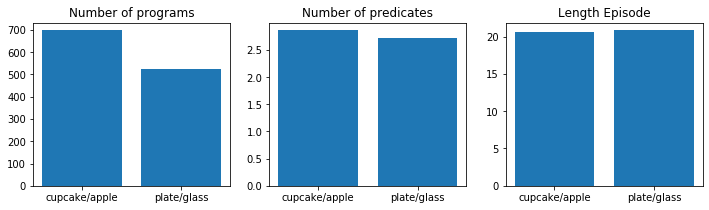

In [154]:

fig, ax2 = plt.subplots(1,3, figsize=(12,3))
x = range(2)
ax = ax2[0]
ax.bar(x, count_episodes)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_title('Number of programs')

ax = ax2[1]
ax.bar(x, count_pred)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_title('Number of predicates')

ax = ax2[2]
ax.bar(x, count_length)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_title('Length Episode')

In [155]:
# Agregate relstions
aggregate_relations = {}

all_relation_names = []
for result in results:
    result_rel = result['obj_relations']
    for result_object, counter_result in result_rel.items():
        all_relation_names += list(counter_result.keys())

all_relation_names = list(set(all_relation_names))
relation_name_to_index = {rel_name: ind for ind, rel_name in enumerate(all_relation_names)}

# For every object, a list of counts
all_relations = {}
for task_name in names:
    all_relations[task_name] = {}
    for object_name_interest in objects_interest:
        all_relations[task_name][object_name_interest] = [0 for _ in all_relation_names]
    
for result in results:
    task_name = result['pred_name']
    result_rel = result['obj_relations']
    for result_object, counter_result in result_rel.items():
        for relation_name, relation_count in counter_result.items():
            index = relation_name_to_index[relation_name]
            all_relations[task_name][result_object][index] += relation_count

# Average over episodes
for index_task, task_name in enumerate(names):
    count_ep = count_length[index_task]
    for object_interest in objects_interest:
        all_relations[task_name][object_interest] = np.array(all_relations[task_name][object_interest])/count_ep
            
            
# len(all_relation_names)

# for result in results:
#     for obj_name in objects_interest:
        
# results[0]['obj_relations']

plate
[24.29534544 33.80011132  0.         13.62673068  0.          0.
  6.54664997 20.17338064 36.56425242  4.75238294  0.          0.
 20.70681138  0.          0.          5.28581368 33.26668058  0.
 16.05141585  0.          0.          0.          0.         82.73025812
  6.30418145 33.26668058  0.         31.71488207  0.         32.73324984]
apple
[ 0.          0.          0.          0.          0.         33.26668058
  0.          0.          9.69874069  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.14548111  8.04995478  0.         30.64802059 12.41438809 94.46573436
  2.8126348   0.          0.          0.          0.          0.        ]
cupcake
[ 0.         15.17852919  0.          0.          0.          0.
  0.          0.          8.04995478  0.          0.          0.
  9.8442218  20.56133027  0.          0.          0.         18.81555695
  0.          1.98824184  0.         21.43421693  8.24392959 70.89779448
  3.49154665

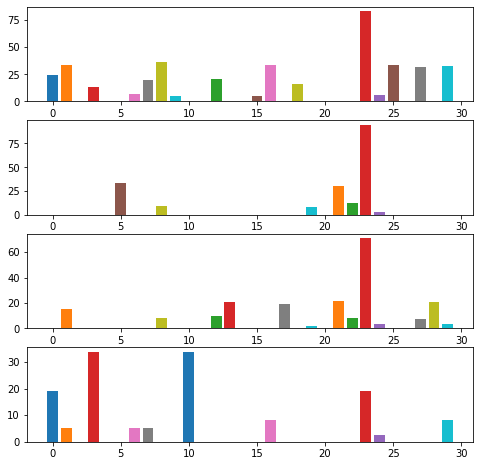

In [156]:
for task_name in [names[0]]:
    fig, ax2 = plt.subplots(4,1, figsize=(8, 8))
    for it_object_interest, name in enumerate(objects_interest):
        print(name)
        array_res = all_relations[task_name][name]
        print(array_res)
        array_res = list(array_res)
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
            ax2[it_object_interest].bar(it, array_res[it], label=relation_name)
            ax.set_xticks([])


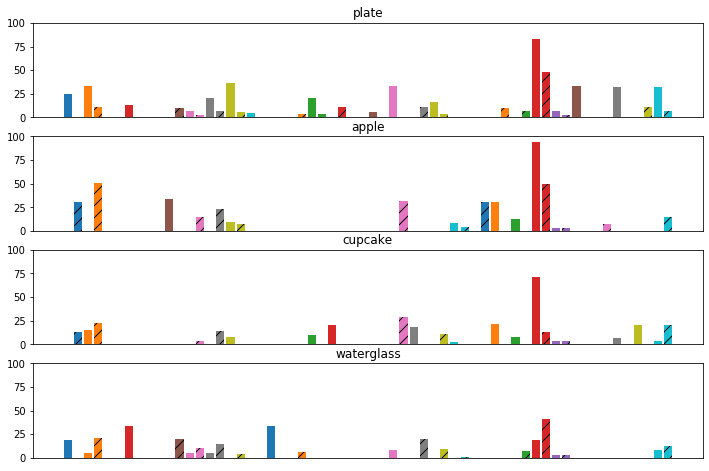

In [184]:

fig, ax2 = plt.subplots(4,1, figsize=(12, 8))
for id_task_name, task_name in enumerate(names):
    pattern = ["", "//"][id_task_name]
    for it_object_interest, name in enumerate(objects_interest):
#         print(name)
        array_res = all_relations[task_name][name]
#         print(array_res)
        array_res = list(array_res)
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
#             ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, width=0.5)
            ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, hatch=pattern)
        
        ax2[it_object_interest].set_title(name)
        ax2[it_object_interest].set_ylim([0,100])
        ax2[it_object_interest].set_xticks([])
        
        ax2[it_object_interest].grid(axis='y')
#     if id_task_name == 0:
#         plt.legend(ncol=3)

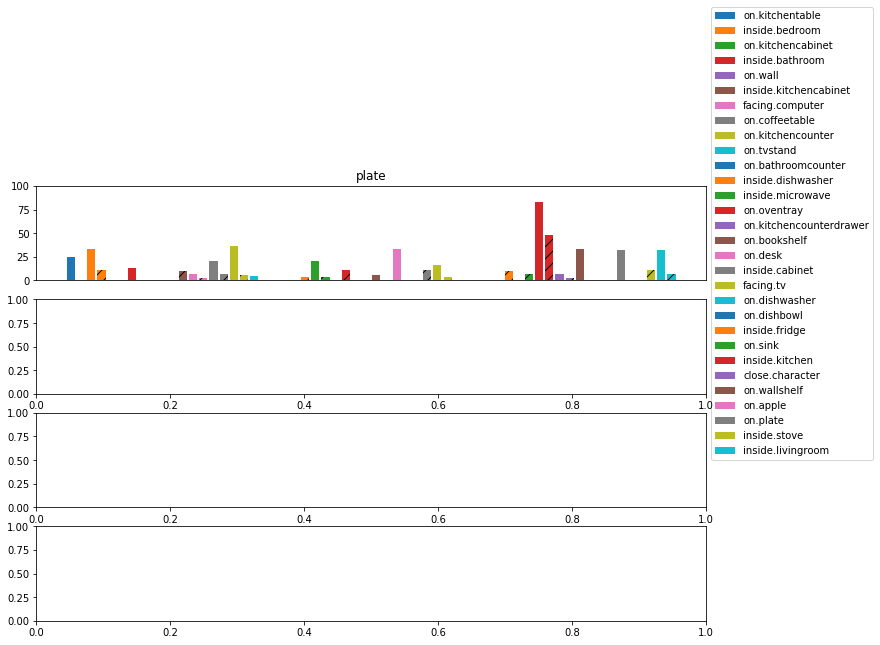

In [195]:

fig, ax2 = plt.subplots(4,1, figsize=(12, 8))
for id_task_name, task_name in enumerate(names):
    pattern = ["", "//"][id_task_name]
    for it_object_interest, name in enumerate(objects_interest[:1]):
#         print(name)
        array_res = all_relations[task_name][name]
#         print(array_res)
        array_res = list(array_res)
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
#             ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, width=0.5)
            ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, hatch=pattern)
        
        ax2[it_object_interest].set_title(name)
        ax2[it_object_interest].set_ylim([0,100])
        ax2[it_object_interest].set_xticks([])
        
        ax2[it_object_interest].grid(axis='y')
    if id_task_name == 0 and it_object_interest == 0:
#         ax2[0].legend(ncol=4)
        ax2[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))